In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import rosbag_pandas
import dateutil


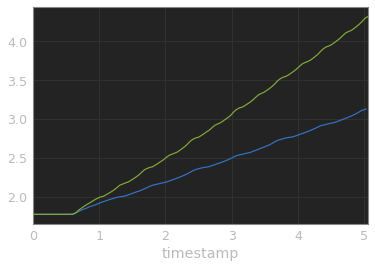

In [82]:
df_25_norm = process(rosbag_pandas.bag_to_dataframe('/home/francesco/Desktop/25_norm.bag'))
df_25_fast = process(rosbag_pandas.bag_to_dataframe('/home/francesco/Desktop/25_fast.bag'))


df_25_norm['pose__pose_position_x'].plot()
df_25_fast['pose__pose_position_x'].plot()


In [72]:
df_25_norm['timestamp']

timestamp
0.000000    0.000000
0.087495    0.087495
0.129988    0.129988
0.170747    0.170747
0.213075    0.213075
0.255984    0.255984
0.298877    0.298877
0.339338    0.339338
0.383024    0.383024
0.425092    0.425092
0.468298    0.468298
0.508938    0.508938
0.551665    0.551665
0.595729    0.595729
0.640645    0.640645
0.683619    0.683619
0.726482    0.726482
0.770197    0.770197
0.813091    0.813091
0.855071    0.855071
0.896872    0.896872
0.938120    0.938120
0.980992    0.980992
1.022145    1.022145
1.062263    1.062263
1.103008    1.103008
1.143417    1.143417
1.185628    1.185628
1.225982    1.225982
1.266156    1.266156
              ...   
3.788831    3.788831
3.831914    3.831914
3.872341    3.872341
3.912866    3.912866
3.956865    3.956865
4.000155    4.000155
4.043152    4.043152
4.085164    4.085164
4.128549    4.128549
4.173358    4.173358
4.217674    4.217674
4.259107    4.259107
4.302719    4.302719
4.345689    4.345689
4.386870    4.386870
4.431549    4.431549
4.4

In [123]:
df_25 = rosbag_pandas.bag_to_dataframe('/home/francesco/Desktop/25_called.bag')
df_50 = rosbag_pandas.bag_to_dataframe('/home/francesco/Desktop/50_called.bag')
df_250 = rosbag_pandas.bag_to_dataframe('/home/francesco/Desktop/250_called.bag')

In [124]:
len(df_25), len(df_50), len(df_250)

(127, 252, 1276)

In [125]:
def process(df):
    df['ros_time'] = df.index
    df['timestamp'] = df['ros_time'].apply(lambda x: dateutil.parser.parse(str(x)).timestamp())
    df['timestamp'] -= df['timestamp'][0]
    df = df.set_index(df['timestamp'])
    
#     df = df[df['timestamp'] >= 1]
#     df['pose__pose_position_x'].plot()
    
    return df

In [126]:
df_25 = process(df_25)
df_50 = process(df_50)
df_250 = process(df_250)

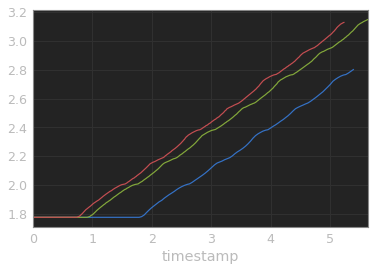

In [127]:
df_25['pose__pose_position_x'].plot()
df_50['pose__pose_position_x'].plot()
df_250['pose__pose_position_x'].plot()



In [92]:
df = rosbag_pandas.bag_to_dataframe('/media/francesco/saetta/krock-dataset/92/train/bags/bars1/1550616906.6299658.bag')

In [93]:
df['ros_time'] = df.index

In [88]:
from utilities.postprocessing.postprocessing import DataFrameHandler, PostProcessingConfig, PatchesHandler
from utilities.postprocessing.utils import *

/home/francesco/.local/lib/python3.6/site-packages/skimage/novice/__init__.py:103: UserWarning: The `skimage.novice` module was deprecated in version 0.14. It will be removed in 0.16.
  warnings.warn("The `skimage.novice` module was deprecated in version 0.14. "


In [89]:
config = PostProcessingConfig(base_dir='./test/',
                              maps_folder='/home/francesco/Documents/Master-Thesis/core/maps/test/',
                              # csv_dir='/home/francesco/Desktop/carino/vaevictis/data/train_no_tail#2/csv/',
                              out_dir='./test/',
                              patch_size=88,
                              advancement_th=0.45,
                              skip_every=12,
                              translation=[5, 5],
                              time_window=500,
                              name='test')
handle1 = DataFrameHandler(config=config)
handle = PatchesHandler(config=config)

In [90]:
len(df)

NameError: name 'df' is not defined

In [141]:
df = df.reset_index(drop=True)


idx = df[df['timestamp'] > 2].index[0]
idx

1040

0.6521796749053917

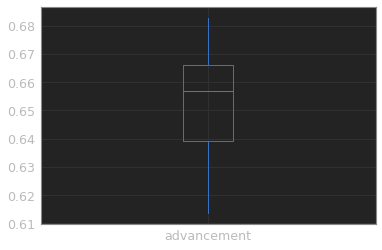

In [115]:
x = df_convert_quaterion2euler(df_25)
x = handle1.extract_cos_sin(x)
x = handle.df_add_advancement(x, 25 * 2)

x['advancement'].plot.box()
x['advancement'].mean()

0.6759632231869478

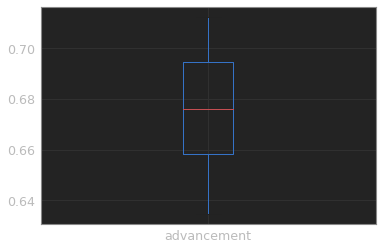

In [116]:
x = df_convert_quaterion2euler(df_50)
x = handle1.extract_cos_sin(x)
x = handle.df_add_advancement(x, 50 * 2)

x['advancement'].plot.box()
x['advancement'].mean()

0.6235622492774299

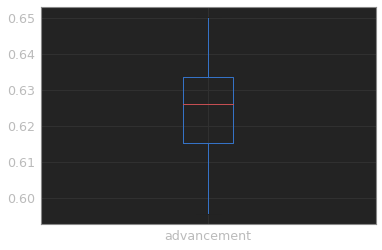

In [117]:
x = df_convert_quaterion2euler(df_250)
x = handle1.extract_cos_sin(x)
x = handle.df_add_advancement(x, 250 * 2)

x['advancement'].plot.box()
x['advancement'].mean()

In [87]:
df = pd.read_csv('/media/francesco/saetta/krock-dataset/92/train/csvs/bars1/1550616906.6299658-complete.csv')
df[df['index'] < 2].shape

(526, 16)

In [5]:
hm = np.zeros((200,200))

offset = 42
xc, yc = hm.shape[0] //2, hm.shape[1]//2

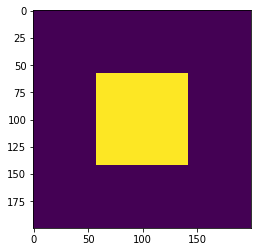

In [6]:
hm[xc - offset: xc + offset , yc - offset: yc + offset] = 255
# hm[:,65:65 + 20] = 255
plt.imshow(hm.squeeze())
plt.show()

In [7]:
cv2.imwrite('/home/francesco/Desktop/center.png', hm)

True